In [ ]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# directory = "../dane/gtfs-drive/"
directory = "../data/gtfsy/"
day = '2023-06-15'

In [ ]:
def get_df(directory, day):
    filepath = directory + day
    extension = ".gtfs"
    routes_df = pd.read_csv(filepath + extension + "/routes.txt")
    stop_times_df = pd.read_csv(filepath + extension + "/stop_times.txt")
    trips_df = pd.read_csv(filepath + extension + "/trips.txt")
    rt_stop_times_df = pd.read_csv(filepath + '-rt.gtfs/stop_times.txt')
    merged_df = stop_times_df.merge(trips_df, on = 'trip_id').merge(routes_df, on = 'route_id').merge(rt_stop_times_df, on=['trip_id', 'stop_id'])
    merged_df['arrival_time_x'] = merged_df['arrival_time_x'].str.strip()
    merged_df['arrival_time_y'] = merged_df['arrival_time_y'].str.strip()
    

    # Create the past_midnight column

    merged_df['diff'] = pd.to_timedelta(merged_df['arrival_time_y'], errors='coerce') - pd.to_timedelta(merged_df['arrival_time_x'], errors='coerce')
    merged_df['diff'] = merged_df['diff'].apply(lambda x: pd.Timedelta.total_seconds(x))
    merged_df = merged_df[["route_short_name", "diff"]]

    lower_quantile = merged_df['diff'].quantile(0.025)
    upper_quantile = merged_df['diff'].quantile(0.975)
    # Filter the dataframe to keep values within the 2.5% - 97.5% range
    filtered_df = merged_df[(merged_df['diff'] >= lower_quantile) & (merged_df['diff'] <= upper_quantile)]
    return filtered_df

In [ ]:
def plot_ecdfs(dfs, line):
    ecdfs = []
    for df in dfs:
        sample = df.loc[df['route_short_name'] == line]['diff']
        ecdfs.append(stats.ecdf(sample))
    i = 0
    for ecdf in ecdfs:
        ecdf.cdf.plot(label = f'{i}')
        i = i + 1
    plt.title(f'Empirical CDFs of delays, line: {line}')
    plt.legend()

In [ ]:
dates = ['2023-05-09','2023-05-10', '2023-05-11', '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-23', '2023-05-30', '2023-05-31', '2023-06-01', '2023-06-06', '2023-06-07', '2023-06-13', '2023-06-14', '2023-06-15']

In [ ]:
dfs = []
for date in dates:
    dfs.append(get_df(directory, date))

In [ ]:
intersection = dfs[0]['route_short_name'].unique()
for df in dfs:
    intersection = np.intersect1d(intersection, df['route_short_name'].unique())

In [ ]:
h_stat = []
p_val = []
for line in intersection:
    samples = [x.loc[x['route_short_name']==line]['diff'] for x in dfs]
    kruskal = stats.kruskal(*samples)
    h_stat.append(kruskal.statistic)
    p_val.append(kruskal.pvalue)

In [ ]:
kruskal_df = pd.DataFrame({"line":intersection, "h_stat":np.array(h_stat), "p-val":np.array(p_val)})

In [ ]:
kruskal_df.sort_values(by="p-val", ascending=False)

,line,h_stat,p-val
156,379,20.968186,1.024505e-01
131,262,23.976224,4.612613e-02
102,209,59.264684,1.578112e-07
260,L36,64.756356,1.690821e-08
224,900,67.678260,5.066468e-09
...,...,...,...
212,738,2025.962194,0.000000e+00
136,3,1524.245696,0.000000e+00
132,263,1553.194471,0.000000e+00
207,731,1740.136751,0.000000e+00


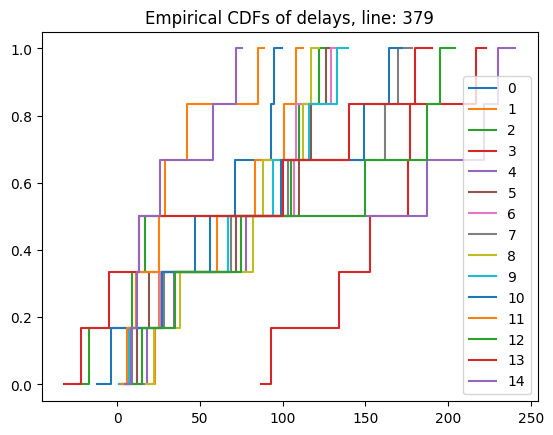

In [ ]:
plot_ecdfs(dfs,"379")

([], [])

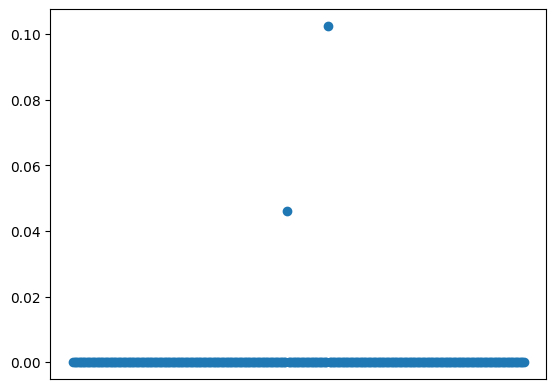

In [ ]:
plt.scatter(kruskal_df['line'], kruskal_df['p-val'])
plt.xticks([], [])

In [ ]:
kruskal_df.sort_values(by="p-val", ascending=False)['line'][0:10]

156    379
131    262
102    209
260    L36
224    900
254    L28
139    308
138    305
243    L17
266    L43
Name: line, dtype: object

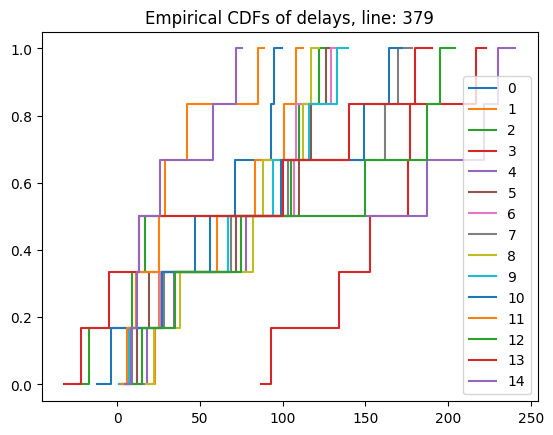

In [ ]:
plot_ecdfs(dfs, "379")

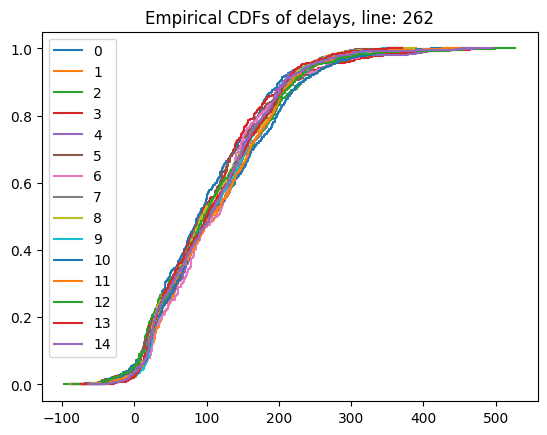

In [ ]:
plot_ecdfs(dfs, "262")

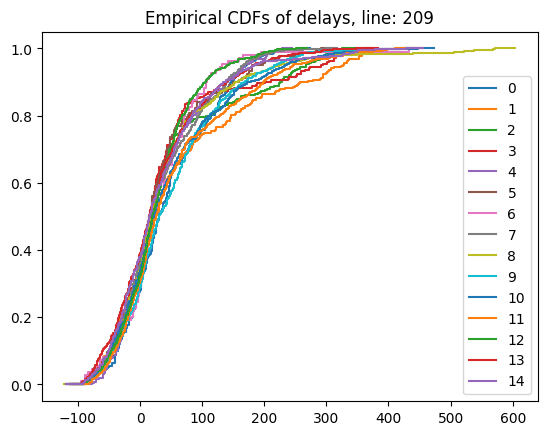

In [ ]:
plot_ecdfs(dfs, "209")

In [ ]:
kruskal_df.sort_values(by="p-val", ascending=True)['line'][0:10]

130     26
18     120
179    523
207    731
212    738
14     116
132    263
12     114
11     112
34     136
Name: line, dtype: object

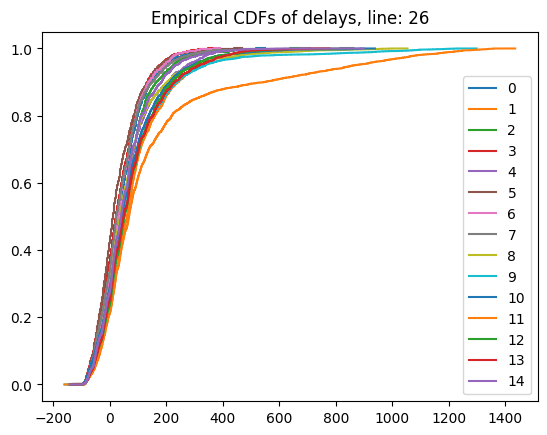

In [ ]:
plot_ecdfs(dfs, "26")

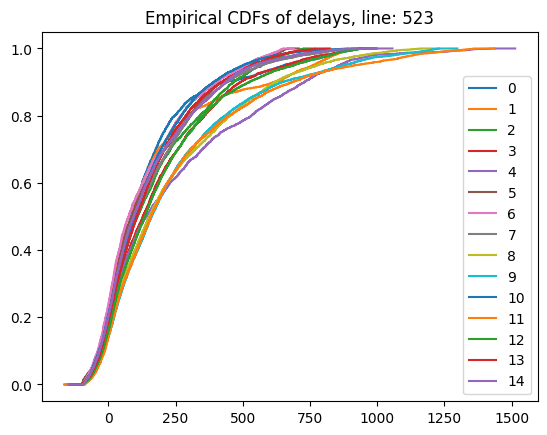

In [ ]:
plot_ecdfs(dfs, "523")

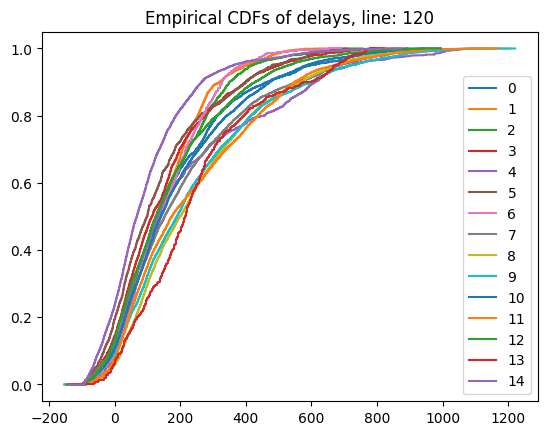

In [ ]:
plot_ecdfs(dfs, "120")